In [ ]:
!pip install jax[tpu] -f https://storage.googleapis.com/jax-releases/libtpu_releases.html

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git

In [ ]:
!pip install --upgrade diffusers[flax]

In [ ]:
!pip install ipywidgets

In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

In [1]:
import jax
import jax.numpy as jnp

In [2]:
jax.local_devices()

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0),
 TpuDevice(id=1, process_index=0, coords=(1,0,0), core_on_chip=0),
 TpuDevice(id=2, process_index=0, coords=(0,1,0), core_on_chip=0),
 TpuDevice(id=3, process_index=0, coords=(1,1,0), core_on_chip=0)]

In [3]:
#from huggingface_hub import notebook_login
from diffusers import FlaxStableDiffusionPipeline

/home/jetjiang/.local/share/virtualenvs/JAX-in-Action-4ZKdNVe_/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-19 01:04:02.960677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-19 01:04:02.983111: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-19 01:04:02.990093: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-19 01:04:04.028061: W tensorflow/compiler/tf2tensorrt/utils/

In [4]:
from flax.jax_utils import replicate
from flax.training.common_utils import shard
from PIL import Image

In [5]:
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    revision="bf16",
    dtype=jnp.bfloat16,
)

Fetching 15 files: 100%|██████████| 15/15 [00:56<00:00,  3.76s/it]
Some of the weights of FlaxCLIPTextModel were initialized in bfloat16 precision from the model checkpoint at /home/jetjiang/.cache/huggingface/hub/models--runwayml--stable-diffusion-v1-5/snapshots/eb5fd1048921a4f94e627038e4107dfe7c68aca2/text_encoder:
[('text_model', 'embeddings', 'position_embedding', 'embedding'), ('text_model', 'embeddings', 'token_embedding', 'embedding'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm1', 'scale'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'layer_norm2', 'scale'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc1', 'kernel'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'bias'), ('text_model', 'encoder', 'layers', '0', 'mlp', 'fc2', 'kernel'), ('text_model', 'encoder', 'laye

In [6]:
prompts = [
    "Three leopards holding a scarlet rose and in the centre a green rat.",
    "A large glass bottle full of tiny elephants of different colors",
    "HAL-9000 in the style of Picasso",
    "Pink panther drinking a coffee. ",
    "Golden tiger fighting vikings in a modern city, Van Gogh style",
    "A blue Axolotl sitting on an emerald throne.",
    "A pumpkin-shape spaceship spinning around the Moon",
    "Black panther doing his homework",
]

In [7]:
p_params = replicate(params)

In [8]:
prompt_ids = pipeline.prepare_inputs(prompts)
prompt_ids = shard(prompt_ids)

In [9]:
seed = 42
rng = jax.random.PRNGKey(seed)
rng = jax.random.split(rng, jax.device_count())

In [10]:
images = pipeline(prompt_ids, p_params, rng, jit=True).images

In [11]:
def image_grid(imgs, rows, cols):
    w,h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, img in enumerate(imgs): grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

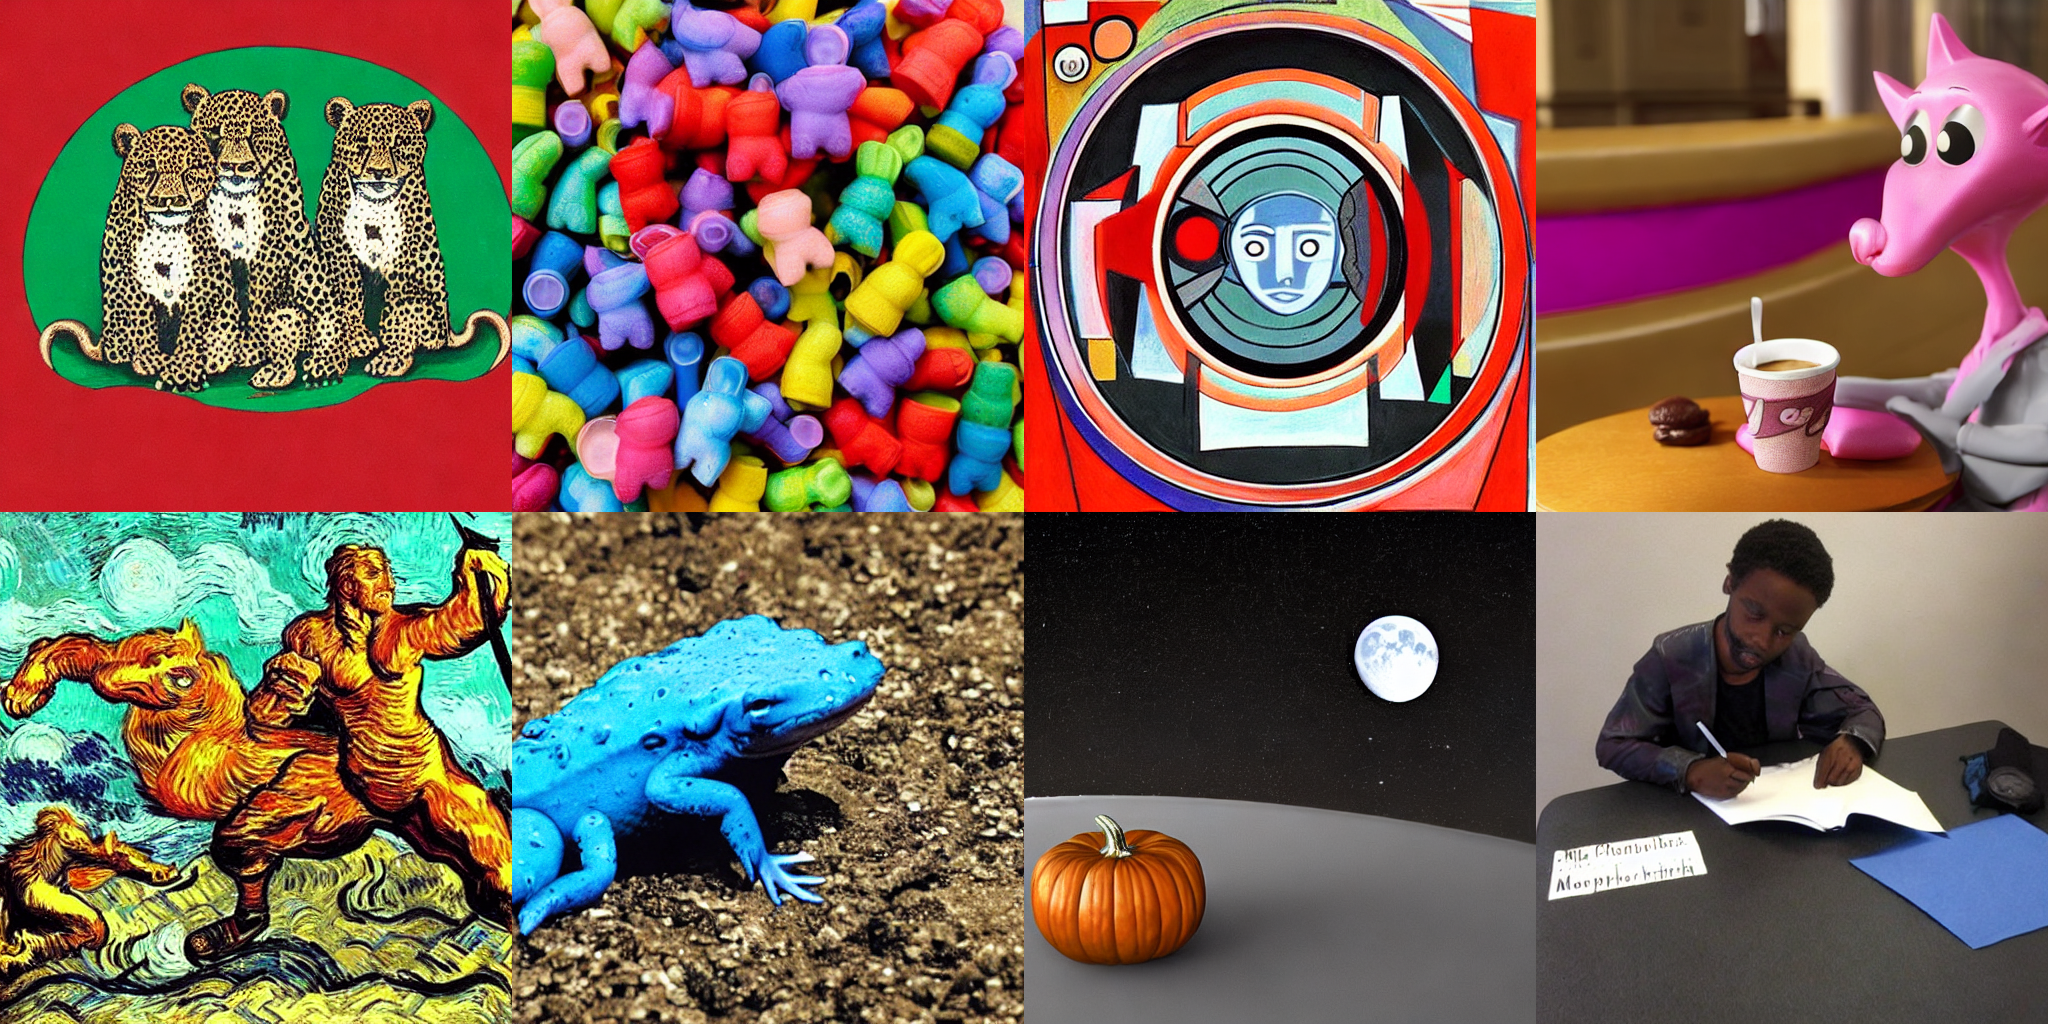

In [14]:
images = images.reshape((images.shape[0] * images.shape[1], ) + images.shape[-3:])
images = pipeline.numpy_to_pil(images)
image_grid(images, 2, 4)